# Transfer Learning with VGG16

In this notebook, I will go over steps to retrain VGG16 net for the skin cancer dataset.

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
base_skin_dir = os.path.join('..', 'Data')
print(base_skin_dir)
print(os.path)
print(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

../Data
<module 'posixpath' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/posixpath.py'>
../Data/HAM10000_metadata.csv


In [ ]:
from glob import glob
print(os.path.splitext)
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

<function splitext at 0x104af2d40>


In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
print(os.path.join(base_skin_dir,'HAM10000_metadata.csv'))
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))


../Data/HAM10000_metadata.csv


In [ ]:
# Count the number of images in each class
class_counts = df['dx'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in lesion_type_dict.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
nv              Melanocytic nevi               6705      
mel             Melanoma                       1113      
bkl             Benign keratosis-like lesions  1099      
bcc             Basal cell carcinoma           514       
akiec           Actinic keratoses              327       
vasc            Vascular lesions               142       
df              Dermatofibroma                 115       
------------------------------------------------------------
Total                                         10015     


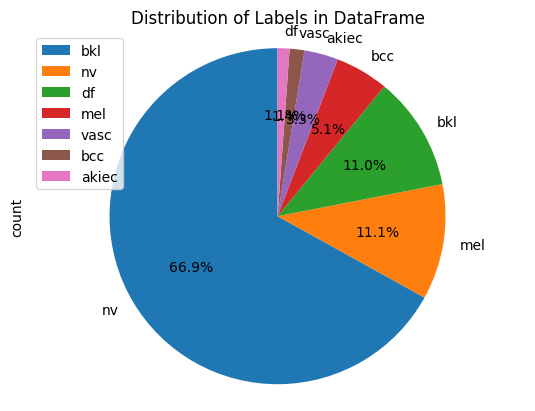

In [ ]:
# Plot pie chart of train_df
df['dx'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['dx'].unique())
plt.show()

In [ ]:
# Count the number of images in each class
class_counts = df['dx'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in lesion_type_dict.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
nv              Melanocytic nevi               6705      
mel             Melanoma                       1113      
bkl             Benign keratosis-like lesions  1099      
bcc             Basal cell carcinoma           514       
akiec           Actinic keratoses              327       
vasc            Vascular lesions               142       
df              Dermatofibroma                 115       
------------------------------------------------------------
Total                                         10015     


In [ ]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("dx").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

/var/folders/5l/_xcxp8dj3jg8wqbs9w6t88600000gn/T/ipykernel_4293/4009429052.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("dx").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [ ]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [ ]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

8

In [ ]:

df['path'] = df['image_id'].map(imageid_path_dict.get) #Image Local Path
df['cell_type'] = df['dx'].map(lesion_type_dict.get) #Full 'dx' name
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes #Unique code for each 'dx'
print(df)

        lesion_id      image_id     dx    dx_type   age     sex  \
0     HAM_0002644  ISIC_0029417  akiec      histo  80.0  female   
1     HAM_0006002  ISIC_0029915  akiec      histo  50.0  female   
2     HAM_0000549  ISIC_0029360  akiec      histo  70.0    male   
3     HAM_0000549  ISIC_0026152  akiec      histo  70.0    male   
4     HAM_0000673  ISIC_0029659  akiec      histo  70.0  female   
...           ...           ...    ...        ...   ...     ...   
5805  HAM_0000415  ISIC_0025680   vasc  consensus  55.0  female   
5806  HAM_0004413  ISIC_0026068   vasc  consensus  55.0  female   
5807  HAM_0004257  ISIC_0025452   vasc  consensus  55.0  female   
5808  HAM_0003829  ISIC_0026349   vasc  consensus  60.0  female   
5809  HAM_0005560  ISIC_0027269   vasc  consensus  60.0  female   

         localization                                             path  \
0                neck  ../Data/HAM10000_images_part_2/ISIC_0029417.jpg   
1                face  ../Data/HAM10000_images_

In [ ]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

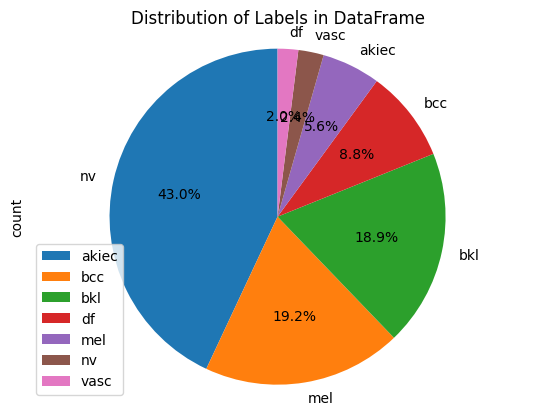

In [ ]:
# Plot pie chart of train_df
df['dx'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['dx'].unique())
plt.show()

In [ ]:
# Count the number of images in each class
class_counts = df['dx'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in lesion_type_dict.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
nv              Melanocytic nevi               2500      
mel             Melanoma                       1113      
bkl             Benign keratosis-like lesions  1099      
bcc             Basal cell carcinoma           514       
akiec           Actinic keratoses              327       
vasc            Vascular lesions               142       
df              Dermatofibroma                 115       
------------------------------------------------------------
Total                                         5810      


In [ ]:
num_classes=len(lesion_type_dict)

In [ ]:
label_map = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}

# Map values in 'dx' column to integer labels using the dictionary
df['label'] = df['dx'].map(label_map)

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image,label
0,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,../Data/HAM10000_images_part_2/ISIC_0029417.jpg,Actinic keratoses,0,"[[[30, 15, 19], [32, 16, 21], [32, 16, 21], [3...",4
1,HAM_0006002,ISIC_0029915,akiec,histo,50.0,female,face,../Data/HAM10000_images_part_2/ISIC_0029915.jpg,Actinic keratoses,0,"[[[28, 14, 14], [31, 15, 15], [35, 19, 19], [4...",4
2,HAM_0000549,ISIC_0029360,akiec,histo,70.0,male,upper extremity,../Data/HAM10000_images_part_2/ISIC_0029360.jpg,Actinic keratoses,0,"[[[17, 7, 12], [20, 9, 12], [21, 10, 14], [29,...",4
3,HAM_0000549,ISIC_0026152,akiec,histo,70.0,male,upper extremity,../Data/HAM10000_images_part_1/ISIC_0026152.jpg,Actinic keratoses,0,"[[[187, 162, 192], [191, 167, 195], [193, 167,...",4
4,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,../Data/HAM10000_images_part_2/ISIC_0029659.jpg,Actinic keratoses,0,"[[[194, 129, 131], [189, 121, 120], [186, 118,...",4


KeyError: 0

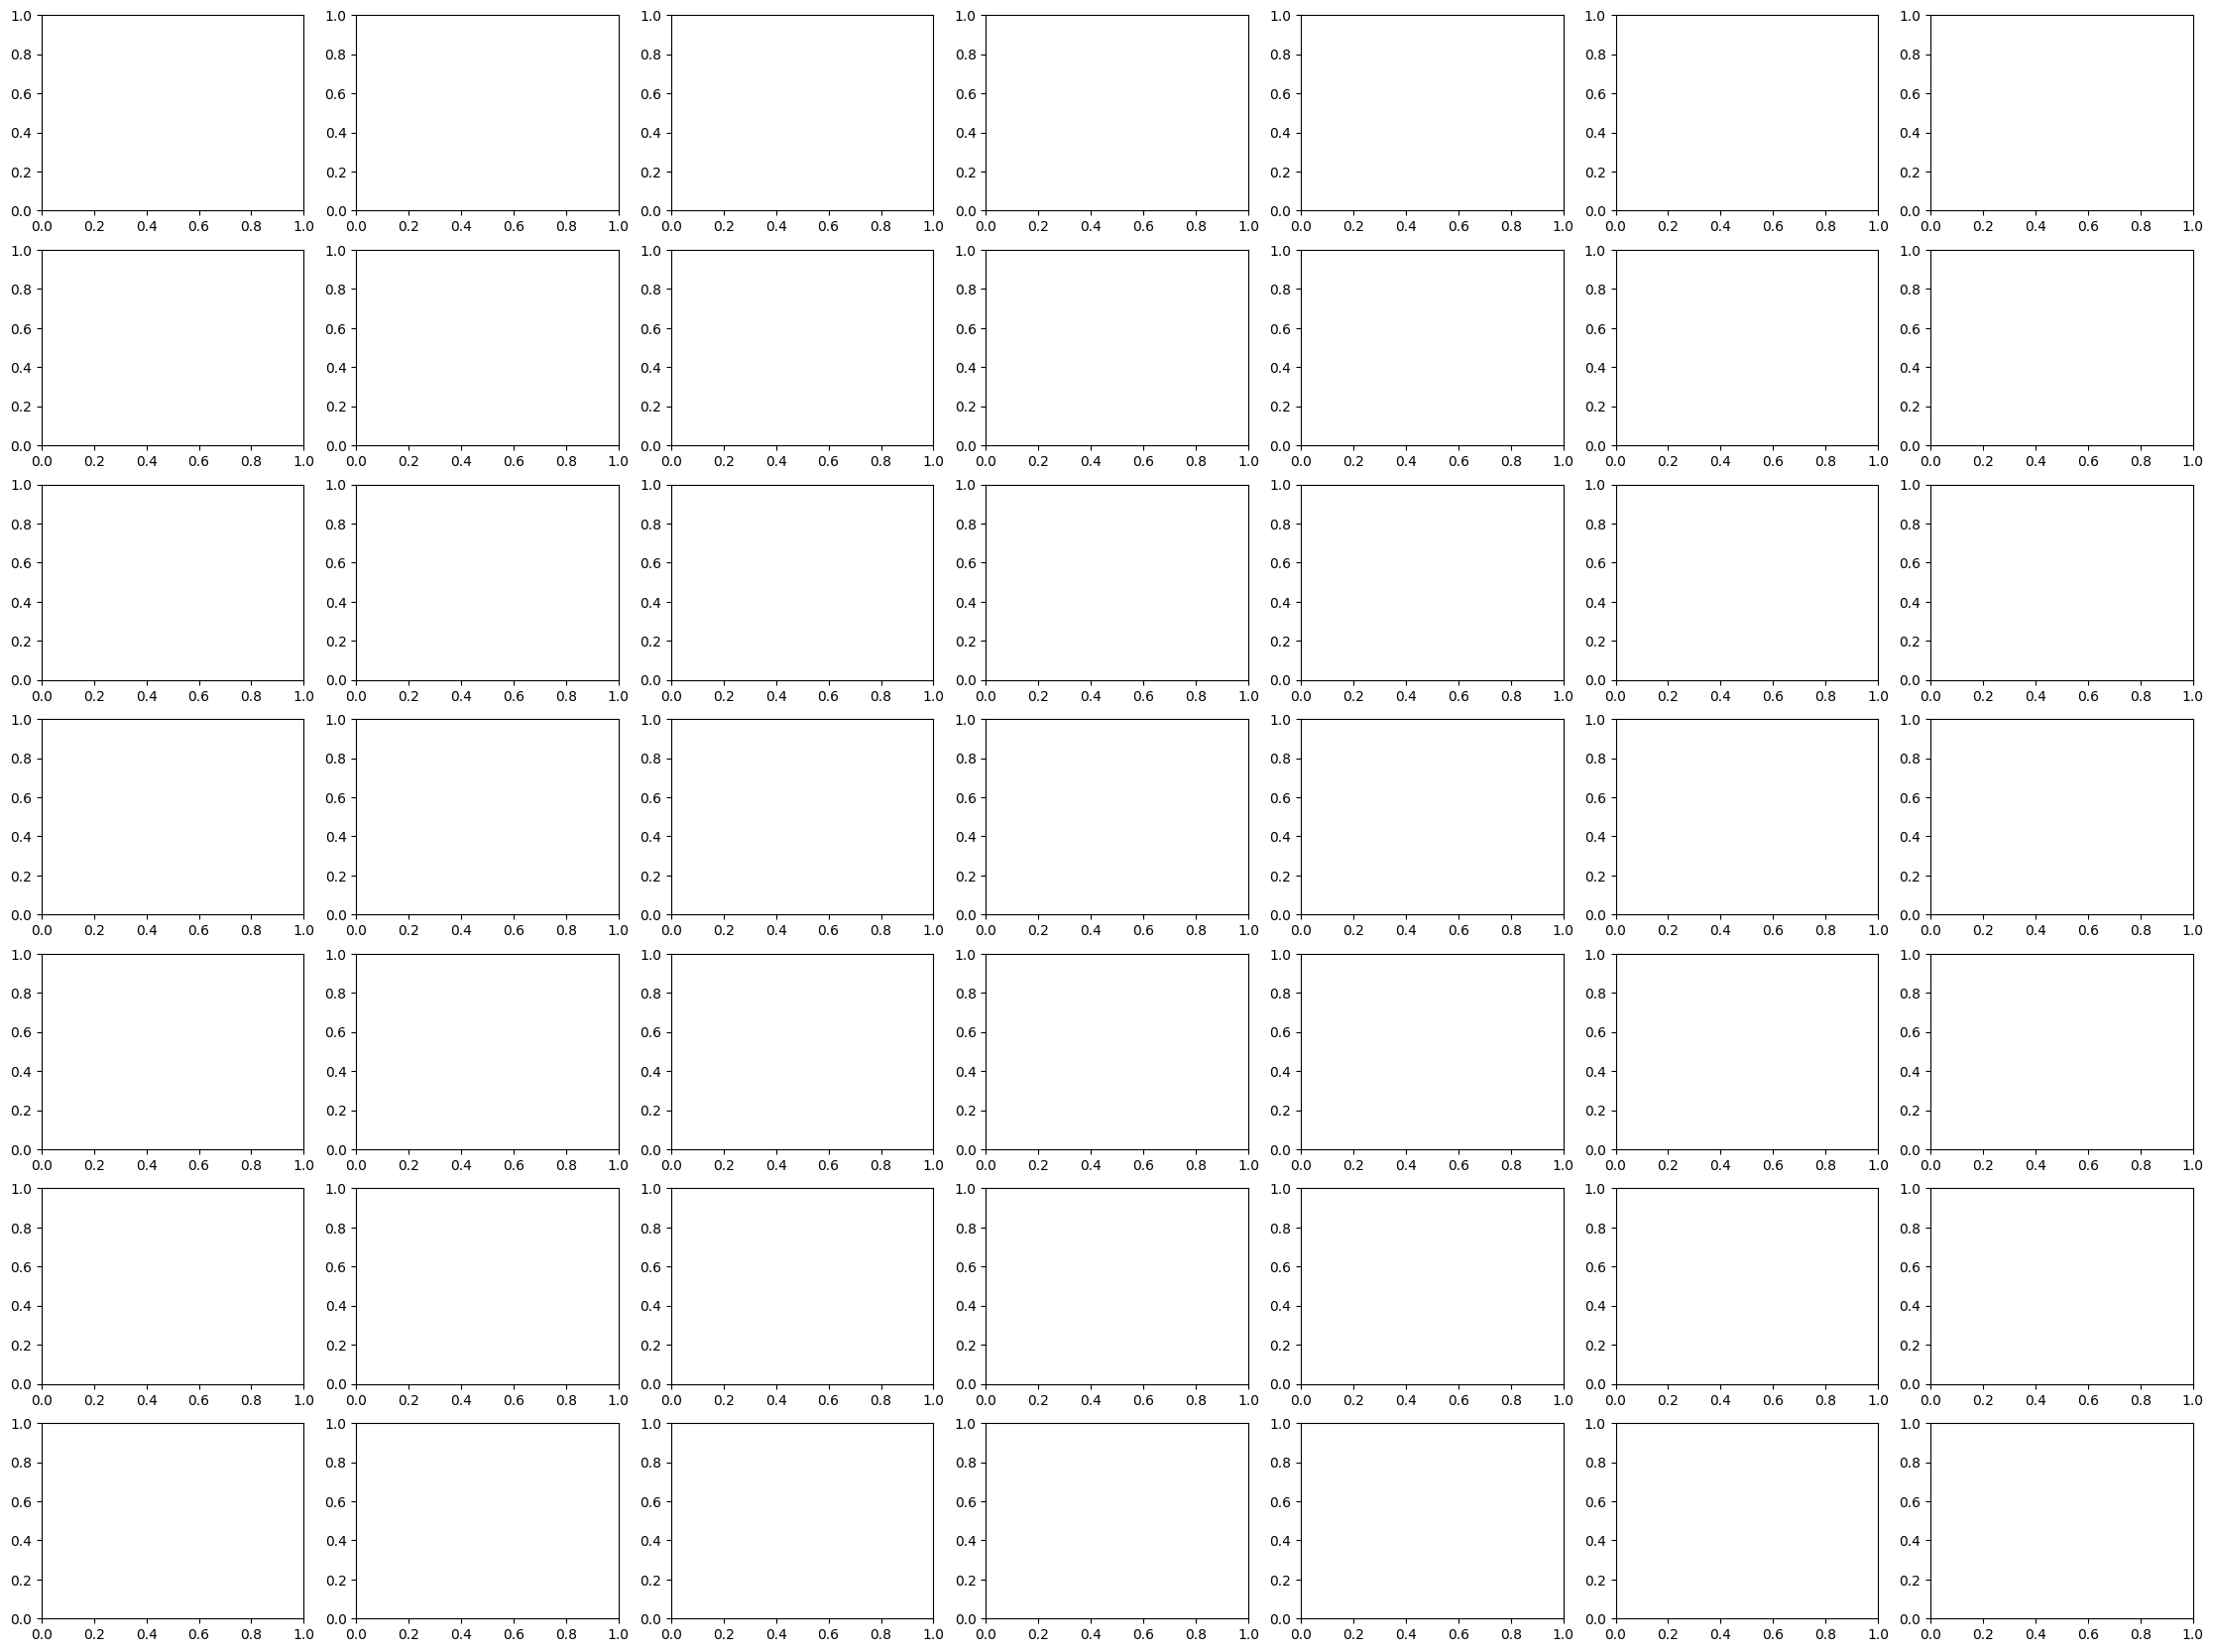

In [ ]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = lesion_type_dict[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
print(df.head())
df['image'].map(lambda x: x.shape).value_counts()

     lesion_id      image_id     dx dx_type   age     sex     localization  \
0  HAM_0002644  ISIC_0029417  akiec   histo  80.0  female             neck   
1  HAM_0006002  ISIC_0029915  akiec   histo  50.0  female             face   
2  HAM_0000549  ISIC_0029360  akiec   histo  70.0    male  upper extremity   
3  HAM_0000549  ISIC_0026152  akiec   histo  70.0    male  upper extremity   
4  HAM_0000673  ISIC_0029659  akiec   histo  70.0  female             face   

                                              path          cell_type  \
0  ../Data/HAM10000_images_part_2/ISIC_0029417.jpg  Actinic keratoses   
1  ../Data/HAM10000_images_part_2/ISIC_0029915.jpg  Actinic keratoses   
2  ../Data/HAM10000_images_part_2/ISIC_0029360.jpg  Actinic keratoses   
3  ../Data/HAM10000_images_part_1/ISIC_0026152.jpg  Actinic keratoses   
4  ../Data/HAM10000_images_part_2/ISIC_0029659.jpg  Actinic keratoses   

   cell_type_idx                                              image  label  
0              

image
(75, 100, 3)    5810
Name: count, dtype: int64

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
        # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
     # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

          # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df._append({'path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)



     # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['path', 'label', 'image']]
    augmented_df = augmented_df._append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()
print(class_counts)
# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in lesion_type_dict.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")


In [ ]:
features = df.drop(columns=['label','path'],axis=1)
target = df['label']

In [ ]:
features.head()

,image
0,"[[[180, 133, 119], [181, 133, 115], [180, 131,..."
1,"[[[209, 197, 201], [211, 200, 203], [212, 202,..."
2,"[[[175, 164, 175], [174, 162, 174], [176, 166,..."
3,"[[[180, 150, 172], [181, 152, 173], [181, 154,..."
4,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [3, 3, 1], ..."


In [ ]:
target.head()

0    4
1    6
2    3
3    1
4    3
Name: label, dtype: object

In [ ]:
print(target.shape,features.shape)

(17500,) (17500, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

In [ ]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [ ]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)

# Iterate over each class label
for i, class_name in enumerate(label_map.values()):
    class_label = list(label_map.keys())[i]
    train_num = int(train_counts[i])
    val_num = int(val_counts[i])
    test_num = int(test_counts[i])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")

print("-" * 90)

# Print the total number of images
total_train = np.sum(train_counts)
total_val = np.sum(val_counts)
total_test = np.sum(test_counts)
total_images = total_train + total_val + total_test
print(f"{'Total':<46} {total_train:<10} {total_val:<12} {total_test:<10} {total_images:<10}")


In [ ]:
df.groupby('label').size()

In [ ]:
input_shape = df['image'][0].shape
print(input_shape)

(75, 100, 3)


## Load in Pretrained VGG16 Model

In [10]:
pre_trained_model = VGG16(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [12]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 512)


## Define the Model

In [13]:
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0         
__________

## Training

### Feature-Extraction

If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of feature extraction first so that weights of the final fully connected layer aren't completely random. The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large and will change the pretrained weights too much.

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
126/126 [==============================] - 91s 720ms/step - loss: 1.2934 - acc: 0.6207 - val_loss: 1.0926 - val_acc: 0.6652
Epoch 2/3
126/126 [==============================] - 84s 667ms/step - loss: 1.0835 - acc: 0.6666 - val_loss: 0.9895 - val_acc: 0.6674
Epoch 3/3
126/126 [==============================] - 85s 676ms/step - loss: 1.0268 - acc: 0.6686 - val_loss: 1.0094 - val_acc: 0.6588


Let's fine tune the last convolutional block of VGG net. I only use learning_rate = 0.0001 with very high momentum = 0.9 and train for 35 epochs only so that the original weights of pretrained VGG net won't be changed too much. learning_rate_reduction function is used and will halve the learning_rate whenever the validation accuracy plateaus for 3 epochs. 